<a href="https://colab.research.google.com/github/JoseMauricioBazagoitiaAyllon/Inteligencia-Artificial-II/blob/main/BarlowTwins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Self-Supervised Learning*

Para tener claro este concepto se necesita poner claro los tipos de aprendizaje que son dos el aprendisaje supervisado y el aprendisaje no supervisado.

![](https://miro.medium.com/max/4416/1*bvMhd_xpVxfJYoKXYp5hug.png)

Dependiendo de los datos disponibles y la tarea que queramos abordar, podemos elegir entre distintos tipos de aprendizaje. Estos son: aprendizaje supervisado, aprendizaje no supervisado, aprendizaje semi-supervisado y aprendizaje por refuerzo.

* Aprendizaje supervisado 
El aprendizaje supervisado necesita conjuntos de datos etiquetados, es decir, le decimos al modelo qué es lo que queremos que aprenda, y basandonos en los resultados conseguimos podemos modificar los parametros para mejorar el modelo..
Dependiendo del tipo de etiqueta, dentro del aprendizaje supervisado existen dos tipos de modelos: 
-Modelos de clasificacion
-Modelos de regrecion
* Aprendizaje no supervisado 
El aprendizaje no supervisado trabaja con datos que no han sido etiquetados. No tenemos una etiqueta que predecir. Estos algoritmos se usan principalmente en tareas donde es necesario analizar los datos para extraer nuevo conocimiento o agrupar entidades por afinidad.
* Aprendizaje semi-supervisado 
Este tipo de aprendizaje tiene un poco de los dos anteriores. Usando este enfoque, se comienza etiquetando manualmente algunos datos. Una vez tenemos una pequeña porción de datos etiquetados, entrenamos uno o varios algoritmos de aprendizaje supervisado sobre esa pequeña parte de datos etiquetados y utilizamos los modelos resultantes del entrenamiento para etiquetar el resto de datos.
* Aprendizaje por refuerzo 
el aprendizaje por refuerzo es un método de aprendizaje automático que se basa en recompensar los comportamientos deseados y penalizar los no deseados.
Para profundizar los contextos podria vistar el proximo enlace https://datos.gob.es/es/blog/como-aprenden-las-maquinas-machine-learning-y-sus-diferentes-tipos



# *Barlow Twins*

![](https://user-images.githubusercontent.com/14848164/120419539-b0fab900-c330-11eb-8536-126ce6ce7b85.png)
Pra explicar este modelo esta imagen sera de mucha ayuda, 
en un principio se cuenta un dataset con imagenes sin etiquetaslo cul lo vuelve un modelo de aprendizaje no supervisado, como no se cuenta con etiquetas para medir la perdida este modelo obta por realizar un copia de de los datos, pero esta cpia no sera identica sino constara de de transformaciones laws cuales nos permitira contar con dos caminos que compara.
Esta imagenes que ya cuentan con la transformacion la yamaremos Y^A y Y^B.
cada una de estas imagenes serviran como entrada a para los distintos entrenamiento esto nos lanzara valores para cada dataSet que los de nominaremos embeddings estos enbeddings seran compparadas de nuevo para conseguir lo mas parecido a una matris identidad mediante una funcion denominada Empirical cross-correlation.
danto los resultados finales.
Para un mayor entendimiento contaremos con 2 ejemplos
https://github.com/facebookresearch/barlowtwins 
Ejemplo Git Hub
https://colab.research.google.com/github/juansensio/blog/blob/master/066_ssl/ssl.ipynb
Ejemplo de Sensio

y por ultimo una edicion del cuadernillo de sensio comentado


In [ ]:
import torch
import torchvision
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, train=True):
        trainset = torchvision.datasets.CIFAR10(root='./data', train=train, download=True)
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        self.imgs, self.labels = np.array([np.array(i[0]) for i in trainset]), np.array([i[1] for i in trainset])
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, ix):
        img = self.imgs[ix]
        return torch.from_numpy(img / 255.).permute(2,0,1).float(), torch.tensor(self.labels[ix]).long()

In [ ]:
ds = {
    'train': Dataset(),
    'test': Dataset(train=False)
}

ds['train'].imgs.shape, ds['test'].imgs.shape, 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [ ]:
batch_size = 1024
num_workers = 24
dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
} 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
imgs, labels = next(iter(dl['train']))
imgs.shape, labels.shape

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(torch.Size([1024, 3, 32, 32]), torch.Size([1024]))

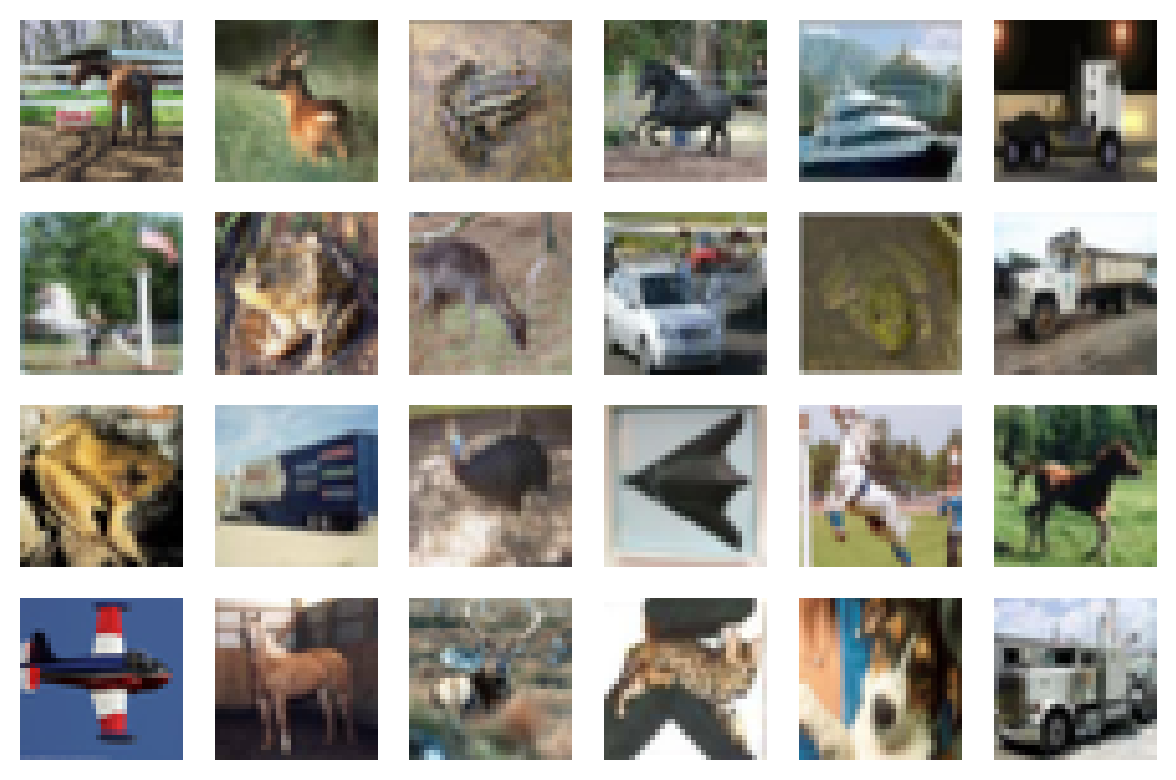

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=200)
c, r = 6, 4
for j in range(r):
    for i in range(c):
        ix = j*c + i
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.imshow(img.permute(1,2,0))
        ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import torch.nn.functional as F
class Model(torch.nn.Module):

    def __init__(self, n_outputs=10, pretrained=False):
        super().__init__()
        self.backbone = torch.nn.Sequential(*list(torchvision.models.resnet18(pretrained=pretrained).children())[:-1])
        if pretrained:
            for param in self.backbone.parameters():
                param.requires_grad = False
        self.head = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(512, n_outputs)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

In [ ]:
model = Model()
output = model(torch.randn(32, 3, 32, 32))

output.shape

torch.Size([32, 10])

In [ ]:
from tqdm import tqdm 

def step(model, batch, device):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.size(0)
    return loss, acc

def train(model, dl, optimizer, epochs=10, device="cuda"):
    #model.to(device)
    hist = {'loss': [], 'acc': [], 'test_loss': [], 'test_acc': []}
    for e in range(1, epochs+1):
        # train
        model.train()
        l, a = [], []
        bar = tqdm(dl['train'])
        for batch in bar:
            optimizer.zero_grad()
            loss, acc = step(model, batch, device)
            loss.backward()
            optimizer.step()
            l.append(loss.item())
            a.append(acc)
            bar.set_description(f"training... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
        hist['loss'].append(np.mean(l))
        hist['acc'].append(np.mean(a))
        # eval
        model.eval()
        l, a = [], []
        bar = tqdm(dl['test'])
        with torch.no_grad():
            for batch in bar:
                loss, acc = step(model, batch, device)
                l.append(loss.item())
                a.append(acc)
                bar.set_description(f"testing... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
        hist['test_loss'].append(np.mean(l))
        hist['test_acc'].append(np.mean(a))
        # log
        log = f'Epoch {e}/{epochs}'
        for k, v in hist.items():
            log += f' {k} {v[-1]:.4f}'
        print(log)
    return hist

In [ ]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

hist = train(model, dl, optimizer, epochs=3)

  0%|          | 0/49 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import pandas as pd

def plot_hist(hist):
    fig = plt.figure(figsize=(10, 3), dpi=100)
    df = pd.DataFrame(hist)
    ax = plt.subplot(1, 2, 1)
    df[['loss', 'test_loss']].plot(ax=ax)
    ax.grid(True)
    ax = plt.subplot(1, 2, 2)
    df[['acc', 'test_acc']].plot(ax=ax)
    ax.grid(True)
    plt.show()

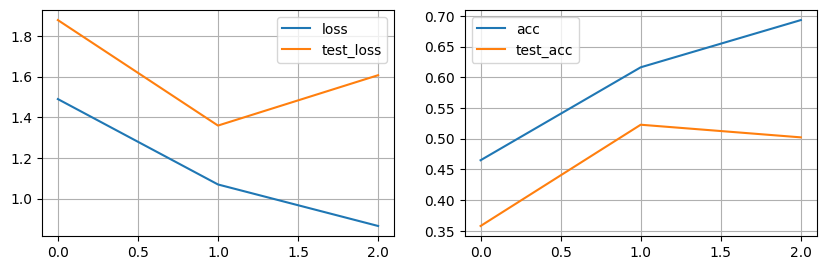

In [ ]:
plot_hist(hist)

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, train=True, pctg=1.):
        trainset = torchvision.datasets.CIFAR10(root='./data', train=train, download=True)
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        self.imgs, self.labels = np.array([np.array(i[0]) for i in trainset]), np.array([i[1] for i in trainset])
        if pctg < 1.:
            unique_labels = list(range(len(self.classes)))
            filtered_imgs, filtered_labels = [], []
            for lab in unique_labels:
                ixs = (self.labels == lab)
                lim = int(ixs.sum()*pctg)
                filtered_imgs += self.imgs[ixs][:lim].tolist()
                filtered_labels += self.labels[ixs][:lim].tolist()
            self.imgs, self.labels = np.array(filtered_imgs), np.array(filtered_labels)        
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, ix):
        img = self.imgs[ix]
        return torch.from_numpy(img / 255.).permute(2,0,1).float(), torch.tensor(self.labels[ix]).long()

In [ ]:
ds = {
    'train': Dataset(pctg=0.01),
    'test': Dataset(train=False)
}

Files already downloaded and verified
Files already downloaded and verified


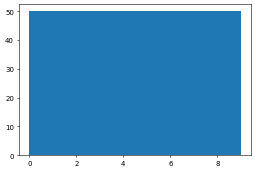

In [ ]:
fig, ax = plt.subplots(dpi=50)
ax.hist(ds['train'].labels, bins=10)
plt.show()

In [ ]:
pctgs = [0.01, 0.1, 1.]
batch_size = 1024
epochs=3
lr=1e-3
hists = []
for pctg in pctgs:
    ds = {
        'train': Dataset(pctg=pctg),
        'test': Dataset(train=False)
    }
    dl = {
        'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
        'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
    } 
    model = Model()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    hist = train(model, dl, optimizer, epochs=epochs)
    hists.append(hist)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
testing... loss 2.2890 acc 0.1359: 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


Epoch 1/3 loss 2.4728 acc 0.1040 test_loss 2.2890 test_acc 0.1359


testing... loss 2.2970 acc 0.0993: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


Epoch 2/3 loss 1.5275 acc 0.5220 test_loss 2.2970 test_acc 0.0993


testing... loss 2.3025 acc 0.1015: 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


Epoch 3/3 loss 0.8939 acc 0.8120 test_loss 2.3025 test_acc 0.1015
Files already downloaded and verified
Files already downloaded and verified


testing... loss 2.3550 acc 0.1114: 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


Epoch 1/3 loss 2.2012 acc 0.2349 test_loss 2.3550 test_acc 0.1114


testing... loss 2.5999 acc 0.1138: 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


Epoch 2/3 loss 1.5138 acc 0.4615 test_loss 2.5999 test_acc 0.1138


testing... loss 3.0446 acc 0.1171: 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


Epoch 3/3 loss 1.1130 acc 0.6061 test_loss 3.0446 test_acc 0.1171
Files already downloaded and verified
Files already downloaded and verified


testing... loss 2.0425 acc 0.3318: 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


Epoch 1/3 loss 1.5028 acc 0.4590 test_loss 2.0425 test_acc 0.3318


testing... loss 1.3250 acc 0.5435: 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


Epoch 2/3 loss 1.0695 acc 0.6170 test_loss 1.3250 test_acc 0.5435


testing... loss 1.1129 acc 0.6136: 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

Epoch 3/3 loss 0.8591 acc 0.6940 test_loss 1.1129 test_acc 0.6136


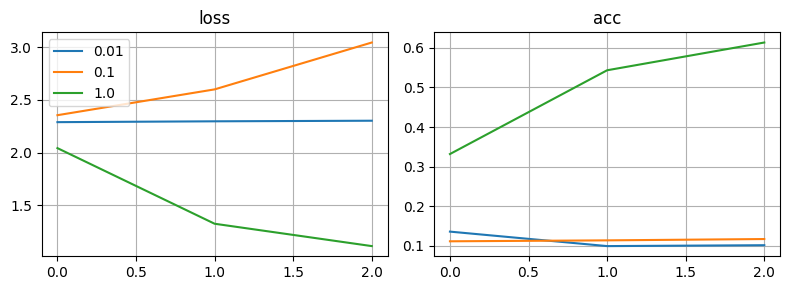

In [ ]:
fig = plt.figure(figsize=(8, 3), dpi=100)
ax = plt.subplot(1, 2, 1)
for i, pctg in enumerate(pctgs):
    ax.plot(hists[i]['test_loss'])
ax.grid(True)
ax.legend(pctgs)
ax.set_title('loss')
ax = plt.subplot(1, 2, 2)
for i, pctg in enumerate(pctgs):
    ax.plot(hists[i]['test_acc'])
ax.grid(True)
ax.set_title('acc')
plt.tight_layout()
plt.show()

In [ ]:
hists = []
for pctg in pctgs:
    ds = {
        'train': Dataset(pctg=pctg),
        'test': Dataset(train=False)
    }
    dl = {
        'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
        'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
    } 
    model = Model(pretrained=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    hist = train(model, dl, optimizer, epochs=epochs)
    hists.append(hist)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

testing... loss 2.3448 acc 0.0870: 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


Epoch 1/3 loss 2.6576 acc 0.0940 test_loss 2.3448 test_acc 0.0870


testing... loss 2.3248 acc 0.0932: 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


Epoch 2/3 loss 2.5135 acc 0.1080 test_loss 2.3248 test_acc 0.0932


testing... loss 2.3100 acc 0.1032: 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


Epoch 3/3 loss 2.4283 acc 0.1180 test_loss 2.3100 test_acc 0.1032
Files already downloaded and verified
Files already downloaded and verified


testing... loss 2.2580 acc 0.1734: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


Epoch 1/3 loss 2.4180 acc 0.1369 test_loss 2.2580 test_acc 0.1734


testing... loss 2.1938 acc 0.2368: 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


Epoch 2/3 loss 2.2305 acc 0.1965 test_loss 2.1938 test_acc 0.2368


testing... loss 2.1268 acc 0.2782: 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


Epoch 3/3 loss 2.0849 acc 0.2526 test_loss 2.1268 test_acc 0.2782
Files already downloaded and verified
Files already downloaded and verified


testing... loss 1.7938 acc 0.3888: 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


Epoch 1/3 loss 2.0325 acc 0.2850 test_loss 1.7938 test_acc 0.3888


testing... loss 1.6828 acc 0.4219: 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


Epoch 2/3 loss 1.7133 acc 0.4114 test_loss 1.6828 test_acc 0.4219


testing... loss 1.6369 acc 0.4401: 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

Epoch 3/3 loss 1.6343 acc 0.4379 test_loss 1.6369 test_acc 0.4401


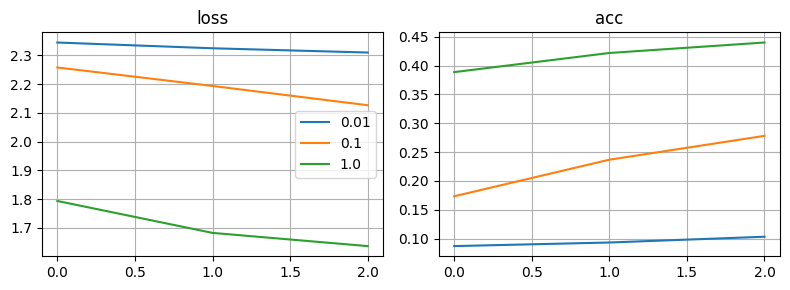

In [ ]:
fig = plt.figure(figsize=(8, 3), dpi=100)
ax = plt.subplot(1, 2, 1)
for i, pctg in enumerate(pctgs):
    ax.plot(hists[i]['test_loss'])
ax.grid(True)
ax.legend(pctgs)
ax.set_title('loss')
ax = plt.subplot(1, 2, 2)
for i, pctg in enumerate(pctgs):
    ax.plot(hists[i]['test_acc'])
ax.grid(True)
ax.set_title('acc')
plt.tight_layout()
plt.show()


![](https://user-images.githubusercontent.com/14848164/120419539-b0fab900-c330-11eb-8536-126ce6ce7b85.png)

In [ ]:
import torch
import torchvision

class SSLDataset(torch.utils.data.Dataset):
    def __init__(self, trans):
        self.trans = trans
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
        self.imgs = np.array([np.array(i[0]) for i in trainset])
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, ix):
        img = self.imgs[ix]
        img1 = self.trans(image=img)['image']
        img2 = self.trans(image=img)['image']
        return torch.from_numpy(img1 / 255.).permute(2,0,1).float(), torch.from_numpy(img2 / 255.).permute(2,0,1).float()

In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 113 kB 7.0 MB/s 
     |████████████████████████████████| 48.3 MB 101 kB/s 
albumentations==1.2.0 is successfully installed


In [ ]:
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install opencv-python==4.5.5.64

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.5 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [ ]:
import numpy as np

#import torchvision.transforms as T
import albumentations as A

trans = A.Compose([
    #A.RandomResizedCrop(32, 32),
    #A.augmentations.RandomSizedCrop(32,32),
    #T.RandomSizedCrop(32,32),
    #A.augmentations.transforms.RandomSizedCrop(32,32),
    A.RandomCrop(32, 32),
    A.HorizontalFlip(p=0.5),
    #A.ColorJitter(p=0.3),
    A.ToGray(p=0.3),
    #A.GaussianBlur(),
    
    #torchvision.transforms.ColorJitter(0.3,0.3,0.3)
   
    
])

SSLds = SSLDataset(trans)

Files already downloaded and verified


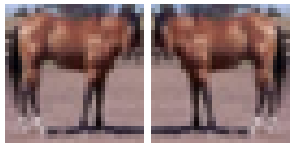

In [ ]:







import matplotlib.pyplot as plt
import random

ix = random.randint(0, len(SSLds))
img1, img2 = SSLds[ix]
fig = plt.figure(dpi=50)
ax = plt.subplot(1, 2, 1)
ax.imshow(img1.permute(1,2,0))
ax.axis('off')
ax = plt.subplot(1, 2, 2)
ax.imshow(img2.permute(1,2,0))
ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
class SSLModel(torch.nn.Module):

    def __init__(self, f=512):
        super().__init__()
        self.backbone = torch.nn.Sequential(*list(torchvision.models.resnet18().children())[:-1])        
        self.head = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(512, f),
            torch.nn.BatchNorm1d(f),
            torch.nn.ReLU(),
            torch.nn.Linear(f, f),
            torch.nn.BatchNorm1d(f),
            torch.nn.ReLU(),
            torch.nn.Linear(f, f)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

In [ ]:
SSLmodel = SSLModel()
output = SSLmodel(torch.randn(32, 3, 32, 32))

output.shape

torch.Size([32, 512])

In [ ]:
import copy

class FTModel(torch.nn.Module):

    def __init__(self, backbone='SSLbackbone.pt', n_outputs=10):
        super().__init__()
        self.backbone = torch.jit.load(backbone)
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.head = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(512, n_outputs)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

In [ ]:
from tqdm import tqdm 

def SSLeval(SSLmodel):
    torch.jit.script(SSLmodel.backbone.cpu()).save('SSLbackbone.pt')
    ds = {
        'train': Dataset(),
        'test': Dataset(train=False)
    }
    batch_size = 1024
    dl = {
        'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
        'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
    } 
    FTmodel = FTModel('SSLbackbone.pt')
    optimizer = torch.optim.Adam(FTmodel.parameters(), lr=1e-3)
    hist = train(FTmodel, dl, optimizer, epochs=3)
    return hist['acc'][-1], hist['test_acc'][-1]

def SSLstep(model, batch, device, l=5e-3):
    # two randomly augmented versions of x
    x1, x2 = batch
    x1, x2 = x1.to(device), x2.to(device)
    
    # compute representations
    z1 = model(x1)
    z2 = model(x2)
    
    # normalize repr. along the batch dimension
    N, D = z1.shape
    z1_norm = (z1 - z1.mean(0)) / z1.std(0) # NxD
    z2_norm = (z2 - z2.mean(0)) / z2.std(0) # NxD
    
    # cross-correlation matrix
    c = (z1_norm.T @ z2_norm) / N # DxD
    
    # loss
    c_diff = (c - torch.eye(D, device=device)).pow(2) # DxD
    # multiply off-diagonal elems of c_diff by lambda
    d = torch.eye(D, dtype=bool)
    c_diff[~d] *= l
    return c_diff.sum()

def SSLtrain(model, dl, optimizer, scheduler, epochs=10, device="cuda", eval_each=10):
    hist = {'loss': [], 'acc': [], 'test_acc': []}
    for e in range(1, epochs+1):
        model.to(device)
        # train
        model.train()
        l, a = [], []
        bar = tqdm(dl)
        for batch in bar:
            optimizer.zero_grad()
            loss = SSLstep(model, batch, device)
            loss.backward()
            optimizer.step()
            l.append(loss.item())
            bar.set_description(f"training... loss {np.mean(l):.4f}")
        hist['loss'].append(np.mean(l))
        scheduler.step()
        # log
        log = f'Epoch {e}/{epochs}'
        for k, v in hist.items():
            if len(v) > 0:
                log += f' {k} {v[-1]:.4f}'
        print(log)
        # eval
        if not e % eval_each:
            print("evaluating ...")
            val_train_acc, val_test_acc = SSLeval(model)
            hist['acc'].append(val_train_acc)
            hist['test_acc'].append(val_test_acc)
    return hist

In [ ]:
SSLdl = torch.utils.data.DataLoader(SSLds, batch_size=1024, shuffle=True, num_workers=num_workers)
SSLmodel = SSLModel()
optimizer = torch.optim.Adam(SSLmodel.parameters(), lr=1e-4)
epochs = 500
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, pct_start=0.01, max_lr=0.1, total_steps=epochs, verbose=True)
hist = SSLtrain(SSLmodel, SSLdl, optimizer, scheduler, epochs=epochs)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Adjusting learning rate of group 0 to 4.0000e-03.


training... loss 85.0286: 100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Adjusting learning rate of group 0 to 1.8059e-02.
Epoch 1/500 loss 85.0286


training... loss 91.2076: 100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Adjusting learning rate of group 0 to 5.2000e-02.
Epoch 2/500 loss 91.2076


training... loss 49.0191: 100%|██████████| 49/49 [00:20<00:00,  2.34it/s]


Adjusting learning rate of group 0 to 8.5941e-02.
Epoch 3/500 loss 49.0191


training... loss 31.6643: 100%|██████████| 49/49 [00:20<00:00,  2.34it/s]


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 4/500 loss 31.6643


training... loss 20.7383: 100%|██████████| 49/49 [00:21<00:00,  2.33it/s]


Adjusting learning rate of group 0 to 9.9999e-02.
Epoch 5/500 loss 20.7383


training... loss 14.1915: 100%|██████████| 49/49 [00:21<00:00,  2.32it/s]


Adjusting learning rate of group 0 to 9.9996e-02.
Epoch 6/500 loss 14.1915


training... loss 10.2560: 100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Adjusting learning rate of group 0 to 9.9991e-02.
Epoch 7/500 loss 10.2560


training... loss 7.9164: 100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Adjusting learning rate of group 0 to 9.9984e-02.
Epoch 8/500 loss 7.9164


training... loss 6.4049: 100%|██████████| 49/49 [00:21<00:00,  2.29it/s]


Adjusting learning rate of group 0 to 9.9975e-02.
Epoch 9/500 loss 6.4049


training... loss 5.3627: 100%|██████████| 49/49 [00:21<00:00,  2.29it/s]


Adjusting learning rate of group 0 to 9.9964e-02.
Epoch 10/500 loss 5.3627
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


testing... loss 2.0192 acc 0.2827: 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


Epoch 1/3 loss 2.1645 acc 0.2314 test_loss 2.0192 test_acc 0.2827


testing... loss 1.9873 acc 0.2944: 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


Epoch 2/3 loss 2.0119 acc 0.2833 test_loss 1.9873 test_acc 0.2944


testing... loss 1.9750 acc 0.2957: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Epoch 3/3 loss 1.9915 acc 0.2879 test_loss 1.9750 test_acc 0.2957


training... loss 4.6603: 100%|██████████| 49/49 [00:22<00:00,  2.21it/s]


Adjusting learning rate of group 0 to 9.9951e-02.
Epoch 11/500 loss 4.6603 acc 0.2879 test_acc 0.2957


training... loss 11.0474: 100%|██████████| 49/49 [00:22<00:00,  2.23it/s]


Adjusting learning rate of group 0 to 9.9936e-02.
Epoch 12/500 loss 11.0474 acc 0.2879 test_acc 0.2957


training... loss 7.6669: 100%|██████████| 49/49 [00:22<00:00,  2.23it/s]


Adjusting learning rate of group 0 to 9.9918e-02.
Epoch 13/500 loss 7.6669 acc 0.2879 test_acc 0.2957


training... loss 6.1402: 100%|██████████| 49/49 [00:21<00:00,  2.23it/s]


Adjusting learning rate of group 0 to 9.9899e-02.
Epoch 14/500 loss 6.1402 acc 0.2879 test_acc 0.2957


training... loss 5.3562: 100%|██████████| 49/49 [00:22<00:00,  2.22it/s]


Adjusting learning rate of group 0 to 9.9878e-02.
Epoch 15/500 loss 5.3562 acc 0.2879 test_acc 0.2957


training... loss 4.7133: 100%|██████████| 49/49 [00:21<00:00,  2.24it/s]


Adjusting learning rate of group 0 to 9.9855e-02.
Epoch 16/500 loss 4.7133 acc 0.2879 test_acc 0.2957


training... loss 4.2014: 100%|██████████| 49/49 [00:22<00:00,  2.22it/s]


Adjusting learning rate of group 0 to 9.9830e-02.
Epoch 17/500 loss 4.2014 acc 0.2879 test_acc 0.2957


training... loss 3.7707: 100%|██████████| 49/49 [00:22<00:00,  2.22it/s]


Adjusting learning rate of group 0 to 9.9803e-02.
Epoch 18/500 loss 3.7707 acc 0.2879 test_acc 0.2957


training... loss 3.6090: 100%|██████████| 49/49 [00:21<00:00,  2.23it/s]


Adjusting learning rate of group 0 to 9.9774e-02.
Epoch 19/500 loss 3.6090 acc 0.2879 test_acc 0.2957


training... loss 3.3264: 100%|██████████| 49/49 [00:22<00:00,  2.23it/s]


Adjusting learning rate of group 0 to 9.9742e-02.
Epoch 20/500 loss 3.3264 acc 0.2879 test_acc 0.2957
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


testing... loss 2.0039 acc 0.2749: 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Epoch 1/3 loss 2.0811 acc 0.2450 test_loss 2.0039 test_acc 0.2749


testing... loss 1.9910 acc 0.2760: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Epoch 2/3 loss 2.0034 acc 0.2707 test_loss 1.9910 test_acc 0.2760


testing... loss 1.9852 acc 0.2862: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Epoch 3/3 loss 1.9942 acc 0.2749 test_loss 1.9852 test_acc 0.2862


training... loss 3.1703: 100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


Adjusting learning rate of group 0 to 9.9709e-02.
Epoch 21/500 loss 3.1703 acc 0.2749 test_acc 0.2862


training... loss 3.0464: 100%|██████████| 49/49 [00:22<00:00,  2.21it/s]


Adjusting learning rate of group 0 to 9.9674e-02.
Epoch 22/500 loss 3.0464 acc 0.2749 test_acc 0.2862


training... loss 2.9646: 100%|██████████| 49/49 [00:21<00:00,  2.23it/s]


Adjusting learning rate of group 0 to 9.9637e-02.
Epoch 23/500 loss 2.9646 acc 0.2749 test_acc 0.2862


training... loss 2.8807: 100%|██████████| 49/49 [00:22<00:00,  2.23it/s]


Adjusting learning rate of group 0 to 9.9598e-02.
Epoch 24/500 loss 2.8807 acc 0.2749 test_acc 0.2862


training... loss 2.8240: 100%|██████████| 49/49 [00:22<00:00,  2.20it/s]


Adjusting learning rate of group 0 to 9.9557e-02.
Epoch 25/500 loss 2.8240 acc 0.2749 test_acc 0.2862


training... loss 2.7797: 100%|██████████| 49/49 [00:22<00:00,  2.21it/s]


Adjusting learning rate of group 0 to 9.9513e-02.
Epoch 26/500 loss 2.7797 acc 0.2749 test_acc 0.2862


training... loss 2.7377: 100%|██████████| 49/49 [00:22<00:00,  2.22it/s]


Adjusting learning rate of group 0 to 9.9468e-02.
Epoch 27/500 loss 2.7377 acc 0.2749 test_acc 0.2862


training... loss 2.7393: 100%|██████████| 49/49 [00:22<00:00,  2.21it/s]


Adjusting learning rate of group 0 to 9.9421e-02.
Epoch 28/500 loss 2.7393 acc 0.2749 test_acc 0.2862


training... loss 2.6986: 100%|██████████| 49/49 [00:22<00:00,  2.22it/s]


Adjusting learning rate of group 0 to 9.9372e-02.
Epoch 29/500 loss 2.6986 acc 0.2749 test_acc 0.2862


training... loss 2.6778: 100%|██████████| 49/49 [00:22<00:00,  2.23it/s]


Adjusting learning rate of group 0 to 9.9321e-02.
Epoch 30/500 loss 2.6778 acc 0.2749 test_acc 0.2862
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


testing... loss 2.0201 acc 0.2627: 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


Epoch 1/3 loss 2.1153 acc 0.2323 test_loss 2.0201 test_acc 0.2627


testing... loss 2.0002 acc 0.2714: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Epoch 2/3 loss 2.0141 acc 0.2662 test_loss 2.0002 test_acc 0.2714


testing... loss 1.9933 acc 0.2773: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Epoch 3/3 loss 1.9989 acc 0.2732 test_loss 1.9933 test_acc 0.2773


training... loss 2.6565: 100%|██████████| 49/49 [00:22<00:00,  2.17it/s]


Adjusting learning rate of group 0 to 9.9268e-02.
Epoch 31/500 loss 2.6565 acc 0.2732 test_acc 0.2773


training... loss 2.6337: 100%|██████████| 49/49 [00:22<00:00,  2.21it/s]


Adjusting learning rate of group 0 to 9.9213e-02.
Epoch 32/500 loss 2.6337 acc 0.2732 test_acc 0.2773


training... loss 2.6239: 100%|██████████| 49/49 [00:21<00:00,  2.24it/s]


Adjusting learning rate of group 0 to 9.9156e-02.
Epoch 33/500 loss 2.6239 acc 0.2732 test_acc 0.2773


training... loss 2.6044: 100%|██████████| 49/49 [00:22<00:00,  2.22it/s]


Adjusting learning rate of group 0 to 9.9096e-02.
Epoch 34/500 loss 2.6044 acc 0.2732 test_acc 0.2773


training... loss 2.5866: 100%|██████████| 49/49 [00:22<00:00,  2.21it/s]


Adjusting learning rate of group 0 to 9.9035e-02.
Epoch 35/500 loss 2.5866 acc 0.2732 test_acc 0.2773


training... loss 2.5722: 100%|██████████| 49/49 [00:22<00:00,  2.21it/s]


Adjusting learning rate of group 0 to 9.8972e-02.
Epoch 36/500 loss 2.5722 acc 0.2732 test_acc 0.2773


training... loss 2.5505: 100%|██████████| 49/49 [00:22<00:00,  2.21it/s]


Adjusting learning rate of group 0 to 9.8907e-02.
Epoch 37/500 loss 2.5505 acc 0.2732 test_acc 0.2773


training... loss 2.5569: 100%|██████████| 49/49 [00:22<00:00,  2.21it/s]


Adjusting learning rate of group 0 to 9.8840e-02.
Epoch 38/500 loss 2.5569 acc 0.2732 test_acc 0.2773


training... loss 2.5422: 100%|██████████| 49/49 [00:22<00:00,  2.21it/s]


Adjusting learning rate of group 0 to 9.8771e-02.
Epoch 39/500 loss 2.5422 acc 0.2732 test_acc 0.2773


training... loss 2.5098: 100%|██████████| 49/49 [00:22<00:00,  2.22it/s]


Adjusting learning rate of group 0 to 9.8701e-02.
Epoch 40/500 loss 2.5098 acc 0.2732 test_acc 0.2773
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


testing... loss 2.0029 acc 0.2716: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


Epoch 1/3 loss 2.1008 acc 0.2377 test_loss 2.0029 test_acc 0.2716


testing... loss 1.9970 acc 0.2714: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


Epoch 2/3 loss 2.0093 acc 0.2692 test_loss 1.9970 test_acc 0.2714


testing... loss 1.9869 acc 0.2775: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


Epoch 3/3 loss 1.9990 acc 0.2735 test_loss 1.9869 test_acc 0.2775


training... loss 2.5129: 100%|██████████| 49/49 [00:22<00:00,  2.18it/s]


Adjusting learning rate of group 0 to 9.8628e-02.
Epoch 41/500 loss 2.5129 acc 0.2735 test_acc 0.2775


training... loss 2.5124: 100%|██████████| 49/49 [00:22<00:00,  2.20it/s]


Adjusting learning rate of group 0 to 9.8553e-02.
Epoch 42/500 loss 2.5124 acc 0.2735 test_acc 0.2775


training... loss 2.4776: 100%|██████████| 49/49 [00:22<00:00,  2.21it/s]


Adjusting learning rate of group 0 to 9.8476e-02.
Epoch 43/500 loss 2.4776 acc 0.2735 test_acc 0.2775


training... loss 2.4752: 100%|██████████| 49/49 [00:22<00:00,  2.21it/s]


Adjusting learning rate of group 0 to 9.8397e-02.
Epoch 44/500 loss 2.4752 acc 0.2735 test_acc 0.2775


training... loss 2.4618: 100%|██████████| 49/49 [00:22<00:00,  2.21it/s]


Adjusting learning rate of group 0 to 9.8317e-02.
Epoch 45/500 loss 2.4618 acc 0.2735 test_acc 0.2775


training... loss 2.4514: 100%|██████████| 49/49 [00:21<00:00,  2.23it/s]


Adjusting learning rate of group 0 to 9.8234e-02.
Epoch 46/500 loss 2.4514 acc 0.2735 test_acc 0.2775


training... loss 2.4294: 100%|██████████| 49/49 [00:22<00:00,  2.21it/s]


Adjusting learning rate of group 0 to 9.8150e-02.
Epoch 47/500 loss 2.4294 acc 0.2735 test_acc 0.2775


training... loss 2.4165: 100%|██████████| 49/49 [00:22<00:00,  2.20it/s]


Adjusting learning rate of group 0 to 9.8063e-02.
Epoch 48/500 loss 2.4165 acc 0.2735 test_acc 0.2775


training... loss 2.4033: 100%|██████████| 49/49 [00:22<00:00,  2.21it/s]


Adjusting learning rate of group 0 to 9.7975e-02.
Epoch 49/500 loss 2.4033 acc 0.2735 test_acc 0.2775


training... loss 2.4067: 100%|██████████| 49/49 [00:22<00:00,  2.22it/s]


Adjusting learning rate of group 0 to 9.7884e-02.
Epoch 50/500 loss 2.4067 acc 0.2735 test_acc 0.2775
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


testing... loss 2.0137 acc 0.2717: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


Epoch 1/3 loss 2.0952 acc 0.2385 test_loss 2.0137 test_acc 0.2717


testing... loss 2.0061 acc 0.2790: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


Epoch 2/3 loss 2.0152 acc 0.2689 test_loss 2.0061 test_acc 0.2790


testing... loss 2.0034 acc 0.2731: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


Epoch 3/3 loss 2.0070 acc 0.2706 test_loss 2.0034 test_acc 0.2731


training... loss 2.3955: 100%|██████████| 49/49 [00:22<00:00,  2.20it/s]


Adjusting learning rate of group 0 to 9.7792e-02.
Epoch 51/500 loss 2.3955 acc 0.2706 test_acc 0.2731


training... loss 2.4466: 100%|██████████| 49/49 [00:22<00:00,  2.20it/s]


Adjusting learning rate of group 0 to 9.7698e-02.
Epoch 52/500 loss 2.4466 acc 0.2706 test_acc 0.2731


training... loss 2.4374: 100%|██████████| 49/49 [00:22<00:00,  2.20it/s]


Adjusting learning rate of group 0 to 9.7602e-02.
Epoch 53/500 loss 2.4374 acc 0.2706 test_acc 0.2731


training... loss 2.3827: 100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


Adjusting learning rate of group 0 to 9.7504e-02.
Epoch 54/500 loss 2.3827 acc 0.2706 test_acc 0.2731


training... loss 2.4125: 100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


Adjusting learning rate of group 0 to 9.7404e-02.
Epoch 55/500 loss 2.4125 acc 0.2706 test_acc 0.2731


training... loss 2.3842: 100%|██████████| 49/49 [00:22<00:00,  2.21it/s]


Adjusting learning rate of group 0 to 9.7302e-02.
Epoch 56/500 loss 2.3842 acc 0.2706 test_acc 0.2731


training... loss 2.4707: 100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


Adjusting learning rate of group 0 to 9.7198e-02.
Epoch 57/500 loss 2.4707 acc 0.2706 test_acc 0.2731


training... loss 2.5674: 100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


Adjusting learning rate of group 0 to 9.7092e-02.
Epoch 58/500 loss 2.5674 acc 0.2706 test_acc 0.2731


training... loss 2.3831: 100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


Adjusting learning rate of group 0 to 9.6985e-02.
Epoch 59/500 loss 2.3831 acc 0.2706 test_acc 0.2731


training... loss 2.3385: 100%|██████████| 49/49 [00:22<00:00,  2.20it/s]


Adjusting learning rate of group 0 to 9.6875e-02.
Epoch 60/500 loss 2.3385 acc 0.2706 test_acc 0.2731
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


testing... loss 1.9919 acc 0.2790: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


Epoch 1/3 loss 2.0870 acc 0.2460 test_loss 1.9919 test_acc 0.2790


testing... loss 1.9796 acc 0.2847: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


Epoch 2/3 loss 1.9841 acc 0.2822 test_loss 1.9796 test_acc 0.2847


testing... loss 1.9721 acc 0.2890: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


Epoch 3/3 loss 1.9745 acc 0.2866 test_loss 1.9721 test_acc 0.2890


training... loss 2.3094: 100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


Adjusting learning rate of group 0 to 9.6764e-02.
Epoch 61/500 loss 2.3094 acc 0.2866 test_acc 0.2890


training... loss 2.3021: 100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


Adjusting learning rate of group 0 to 9.6651e-02.
Epoch 62/500 loss 2.3021 acc 0.2866 test_acc 0.2890


training... loss 2.2854: 100%|██████████| 49/49 [00:22<00:00,  2.20it/s]


Adjusting learning rate of group 0 to 9.6535e-02.
Epoch 63/500 loss 2.2854 acc 0.2866 test_acc 0.2890


training... loss 2.2684: 100%|██████████| 49/49 [00:23<00:00,  2.10it/s]


Adjusting learning rate of group 0 to 9.6418e-02.
Epoch 64/500 loss 2.2684 acc 0.2866 test_acc 0.2890


training... loss 2.5509: 100%|██████████| 49/49 [00:22<00:00,  2.20it/s]


Adjusting learning rate of group 0 to 9.6300e-02.
Epoch 65/500 loss 2.5509 acc 0.2866 test_acc 0.2890


training... loss 2.5877: 100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


Adjusting learning rate of group 0 to 9.6179e-02.
Epoch 66/500 loss 2.5877 acc 0.2866 test_acc 0.2890


training... loss 2.3407: 100%|██████████| 49/49 [00:22<00:00,  2.20it/s]


Adjusting learning rate of group 0 to 9.6056e-02.
Epoch 67/500 loss 2.3407 acc 0.2866 test_acc 0.2890


training... loss 2.2816: 100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


Adjusting learning rate of group 0 to 9.5932e-02.
Epoch 68/500 loss 2.2816 acc 0.2866 test_acc 0.2890


training... loss 2.3249: 100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


Adjusting learning rate of group 0 to 9.5805e-02.
Epoch 69/500 loss 2.3249 acc 0.2866 test_acc 0.2890


training... loss 2.2789: 100%|██████████| 49/49 [00:22<00:00,  2.20it/s]


Adjusting learning rate of group 0 to 9.5677e-02.
Epoch 70/500 loss 2.2789 acc 0.2866 test_acc 0.2890
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


testing... loss 1.9905 acc 0.2841: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Epoch 1/3 loss 2.0883 acc 0.2502 test_loss 1.9905 test_acc 0.2841


testing... loss 1.9794 acc 0.2844: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Epoch 2/3 loss 1.9862 acc 0.2826 test_loss 1.9794 test_acc 0.2844


testing... loss 1.9755 acc 0.2855: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Epoch 3/3 loss 1.9737 acc 0.2876 test_loss 1.9755 test_acc 0.2855


training... loss 2.2247: 100%|██████████| 49/49 [00:22<00:00,  2.18it/s]


Adjusting learning rate of group 0 to 9.5547e-02.
Epoch 71/500 loss 2.2247 acc 0.2876 test_acc 0.2855


training... loss 2.2181: 100%|██████████| 49/49 [00:22<00:00,  2.18it/s]


Adjusting learning rate of group 0 to 9.5415e-02.
Epoch 72/500 loss 2.2181 acc 0.2876 test_acc 0.2855


training... loss 2.2380: 100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


Adjusting learning rate of group 0 to 9.5282e-02.
Epoch 73/500 loss 2.2380 acc 0.2876 test_acc 0.2855


training... loss 2.2300: 100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


Adjusting learning rate of group 0 to 9.5146e-02.
Epoch 74/500 loss 2.2300 acc 0.2876 test_acc 0.2855


training... loss 2.2377: 100%|██████████| 49/49 [00:22<00:00,  2.18it/s]


Adjusting learning rate of group 0 to 9.5009e-02.
Epoch 75/500 loss 2.2377 acc 0.2876 test_acc 0.2855


training... loss 5.4350: 100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


Adjusting learning rate of group 0 to 9.4870e-02.
Epoch 76/500 loss 5.4350 acc 0.2876 test_acc 0.2855


training... loss 4.1518: 100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


Adjusting learning rate of group 0 to 9.4729e-02.
Epoch 77/500 loss 4.1518 acc 0.2876 test_acc 0.2855


training... loss 3.6221: 100%|██████████| 49/49 [00:22<00:00,  2.18it/s]


Adjusting learning rate of group 0 to 9.4586e-02.
Epoch 78/500 loss 3.6221 acc 0.2876 test_acc 0.2855


training... loss 3.4691: 100%|██████████| 49/49 [00:22<00:00,  2.18it/s]


Adjusting learning rate of group 0 to 9.4442e-02.
Epoch 79/500 loss 3.4691 acc 0.2876 test_acc 0.2855


training... loss 3.3106: 100%|██████████| 49/49 [00:22<00:00,  2.18it/s]


Adjusting learning rate of group 0 to 9.4295e-02.
Epoch 80/500 loss 3.3106 acc 0.2876 test_acc 0.2855
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


testing... loss 1.9865 acc 0.2748: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Epoch 1/3 loss 2.1041 acc 0.2468 test_loss 1.9865 test_acc 0.2748


testing... loss 1.9658 acc 0.2868: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Epoch 2/3 loss 1.9815 acc 0.2807 test_loss 1.9658 test_acc 0.2868


testing... loss 1.9628 acc 0.2903: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Epoch 3/3 loss 1.9662 acc 0.2872 test_loss 1.9628 test_acc 0.2903


training... loss 3.2368: 100%|██████████| 49/49 [00:22<00:00,  2.17it/s]


Adjusting learning rate of group 0 to 9.4147e-02.
Epoch 81/500 loss 3.2368 acc 0.2872 test_acc 0.2903


training... loss 4.0953: 100%|██████████| 49/49 [00:22<00:00,  2.18it/s]


Adjusting learning rate of group 0 to 9.3998e-02.
Epoch 82/500 loss 4.0953 acc 0.2872 test_acc 0.2903


training... loss 5.3463: 100%|██████████| 49/49 [00:23<00:00,  2.10it/s]


Adjusting learning rate of group 0 to 9.3846e-02.
Epoch 83/500 loss 5.3463 acc 0.2872 test_acc 0.2903


training... loss 4.2606: 100%|██████████| 49/49 [00:22<00:00,  2.17it/s]


Adjusting learning rate of group 0 to 9.3692e-02.
Epoch 84/500 loss 4.2606 acc 0.2872 test_acc 0.2903


training... loss 4.0980: 100%|██████████| 49/49 [00:22<00:00,  2.17it/s]


Adjusting learning rate of group 0 to 9.3537e-02.
Epoch 85/500 loss 4.0980 acc 0.2872 test_acc 0.2903


training... loss 4.0034: 100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


Adjusting learning rate of group 0 to 9.3380e-02.
Epoch 86/500 loss 4.0034 acc 0.2872 test_acc 0.2903


training... loss 3.9274: 100%|██████████| 49/49 [00:22<00:00,  2.18it/s]


Adjusting learning rate of group 0 to 9.3222e-02.
Epoch 87/500 loss 3.9274 acc 0.2872 test_acc 0.2903


training... loss 3.8443: 100%|██████████| 49/49 [00:22<00:00,  2.18it/s]


Adjusting learning rate of group 0 to 9.3061e-02.
Epoch 88/500 loss 3.8443 acc 0.2872 test_acc 0.2903


training... loss 3.7893: 100%|██████████| 49/49 [00:22<00:00,  2.18it/s]


Adjusting learning rate of group 0 to 9.2899e-02.
Epoch 89/500 loss 3.7893 acc 0.2872 test_acc 0.2903


training... loss 3.8216: 100%|██████████| 49/49 [00:22<00:00,  2.18it/s]


Adjusting learning rate of group 0 to 9.2735e-02.
Epoch 90/500 loss 3.8216 acc 0.2872 test_acc 0.2903
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


testing... loss 1.9731 acc 0.2941: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Epoch 1/3 loss 2.0964 acc 0.2589 test_loss 1.9731 test_acc 0.2941


testing... loss 1.9550 acc 0.2986: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Epoch 2/3 loss 1.9618 acc 0.2944 test_loss 1.9550 test_acc 0.2986


testing... loss 1.9547 acc 0.2988: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Epoch 3/3 loss 1.9494 acc 0.2983 test_loss 1.9547 test_acc 0.2988


training... loss 3.6929: 100%|██████████| 49/49 [00:22<00:00,  2.16it/s]


Adjusting learning rate of group 0 to 9.2570e-02.
Epoch 91/500 loss 3.6929 acc 0.2983 test_acc 0.2988


training... loss 3.5887: 100%|██████████| 49/49 [00:22<00:00,  2.18it/s]


Adjusting learning rate of group 0 to 9.2402e-02.
Epoch 92/500 loss 3.5887 acc 0.2983 test_acc 0.2988


training... loss 3.5617: 100%|██████████| 49/49 [00:22<00:00,  2.17it/s]


Adjusting learning rate of group 0 to 9.2233e-02.
Epoch 93/500 loss 3.5617 acc 0.2983 test_acc 0.2988


training... loss 5.9936: 100%|██████████| 49/49 [00:22<00:00,  2.17it/s]


Adjusting learning rate of group 0 to 9.2063e-02.
Epoch 94/500 loss 5.9936 acc 0.2983 test_acc 0.2988


training... loss 6.7577: 100%|██████████| 49/49 [00:22<00:00,  2.17it/s]


Adjusting learning rate of group 0 to 9.1890e-02.
Epoch 95/500 loss 6.7577 acc 0.2983 test_acc 0.2988


training... loss 5.5201: 100%|██████████| 49/49 [00:22<00:00,  2.17it/s]


Adjusting learning rate of group 0 to 9.1716e-02.
Epoch 96/500 loss 5.5201 acc 0.2983 test_acc 0.2988


training... loss 5.3227: 100%|██████████| 49/49 [00:22<00:00,  2.17it/s]


Adjusting learning rate of group 0 to 9.1540e-02.
Epoch 97/500 loss 5.3227 acc 0.2983 test_acc 0.2988


training... loss 5.1908: 100%|██████████| 49/49 [00:22<00:00,  2.18it/s]


Adjusting learning rate of group 0 to 9.1363e-02.
Epoch 98/500 loss 5.1908 acc 0.2983 test_acc 0.2988


training... loss 5.0743: 100%|██████████| 49/49 [00:22<00:00,  2.16it/s]


Adjusting learning rate of group 0 to 9.1184e-02.
Epoch 99/500 loss 5.0743 acc 0.2983 test_acc 0.2988


training... loss 4.9738: 100%|██████████| 49/49 [00:22<00:00,  2.17it/s]


Adjusting learning rate of group 0 to 9.1003e-02.
Epoch 100/500 loss 4.9738 acc 0.2983 test_acc 0.2988
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


testing... loss 2.0506 acc 0.2601: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Epoch 1/3 loss 2.2281 acc 0.2222 test_loss 2.0506 test_acc 0.2601


testing... loss 2.0136 acc 0.2733: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Epoch 2/3 loss 2.0250 acc 0.2653 test_loss 2.0136 test_acc 0.2733


testing... loss 2.0013 acc 0.2797: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Epoch 3/3 loss 2.0052 acc 0.2745 test_loss 2.0013 test_acc 0.2797


training... loss 4.9919: 100%|██████████| 49/49 [00:23<00:00,  2.12it/s]


Adjusting learning rate of group 0 to 9.0821e-02.
Epoch 101/500 loss 4.9919 acc 0.2745 test_acc 0.2797


training... loss 5.0538: 100%|██████████| 49/49 [00:22<00:00,  2.16it/s]


Adjusting learning rate of group 0 to 9.0637e-02.
Epoch 102/500 loss 5.0538 acc 0.2745 test_acc 0.2797


training... loss 4.8401: 100%|██████████| 49/49 [00:22<00:00,  2.18it/s]


Adjusting learning rate of group 0 to 9.0451e-02.
Epoch 103/500 loss 4.8401 acc 0.2745 test_acc 0.2797


training... loss 4.7494: 100%|██████████| 49/49 [00:22<00:00,  2.17it/s]


Adjusting learning rate of group 0 to 9.0264e-02.
Epoch 104/500 loss 4.7494 acc 0.2745 test_acc 0.2797


training... loss 4.7438: 100%|██████████| 49/49 [00:22<00:00,  2.16it/s]


Adjusting learning rate of group 0 to 9.0075e-02.
Epoch 105/500 loss 4.7438 acc 0.2745 test_acc 0.2797


training... loss 5.1311: 100%|██████████| 49/49 [00:22<00:00,  2.16it/s]


Adjusting learning rate of group 0 to 8.9884e-02.
Epoch 106/500 loss 5.1311 acc 0.2745 test_acc 0.2797


training... loss 4.7035: 100%|██████████| 49/49 [00:22<00:00,  2.18it/s]


Adjusting learning rate of group 0 to 8.9692e-02.
Epoch 107/500 loss 4.7035 acc 0.2745 test_acc 0.2797


training... loss 7.0670: 100%|██████████| 49/49 [00:22<00:00,  2.16it/s]


Adjusting learning rate of group 0 to 8.9498e-02.
Epoch 108/500 loss 7.0670 acc 0.2745 test_acc 0.2797


training... loss 6.7188: 100%|██████████| 49/49 [00:22<00:00,  2.17it/s]


Adjusting learning rate of group 0 to 8.9303e-02.
Epoch 109/500 loss 6.7188 acc 0.2745 test_acc 0.2797


training... loss 5.7810: 100%|██████████| 49/49 [00:22<00:00,  2.16it/s]


Adjusting learning rate of group 0 to 8.9106e-02.
Epoch 110/500 loss 5.7810 acc 0.2745 test_acc 0.2797
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


testing... loss 2.0880 acc 0.2495: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Epoch 1/3 loss 2.3518 acc 0.2105 test_loss 2.0880 test_acc 0.2495


testing... loss 2.0552 acc 0.2598: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Epoch 2/3 loss 2.0727 acc 0.2575 test_loss 2.0552 test_acc 0.2598


testing... loss 2.0377 acc 0.2662: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Epoch 3/3 loss 2.0556 acc 0.2584 test_loss 2.0377 test_acc 0.2662


training... loss 5.6365: 100%|██████████| 49/49 [00:22<00:00,  2.15it/s]


Adjusting learning rate of group 0 to 8.8907e-02.
Epoch 111/500 loss 5.6365 acc 0.2584 test_acc 0.2662


training... loss 5.5235: 100%|██████████| 49/49 [00:22<00:00,  2.15it/s]


Adjusting learning rate of group 0 to 8.8707e-02.
Epoch 112/500 loss 5.5235 acc 0.2584 test_acc 0.2662


training... loss 5.3782: 100%|██████████| 49/49 [00:22<00:00,  2.17it/s]


Adjusting learning rate of group 0 to 8.8505e-02.
Epoch 113/500 loss 5.3782 acc 0.2584 test_acc 0.2662


training... loss 5.3229: 100%|██████████| 49/49 [00:22<00:00,  2.16it/s]


Adjusting learning rate of group 0 to 8.8302e-02.
Epoch 114/500 loss 5.3229 acc 0.2584 test_acc 0.2662


training... loss 5.2736: 100%|██████████| 49/49 [00:22<00:00,  2.16it/s]


Adjusting learning rate of group 0 to 8.8098e-02.
Epoch 115/500 loss 5.2736 acc 0.2584 test_acc 0.2662


training... loss 5.4204: 100%|██████████| 49/49 [00:22<00:00,  2.17it/s]


Adjusting learning rate of group 0 to 8.7891e-02.
Epoch 116/500 loss 5.4204 acc 0.2584 test_acc 0.2662


training... loss 5.2020: 100%|██████████| 49/49 [00:22<00:00,  2.18it/s]


Adjusting learning rate of group 0 to 8.7683e-02.
Epoch 117/500 loss 5.2020 acc 0.2584 test_acc 0.2662


training... loss 5.2691: 100%|██████████| 49/49 [00:22<00:00,  2.16it/s]


Adjusting learning rate of group 0 to 8.7474e-02.
Epoch 118/500 loss 5.2691 acc 0.2584 test_acc 0.2662


training... loss 5.2627: 100%|██████████| 49/49 [00:22<00:00,  2.15it/s]


Adjusting learning rate of group 0 to 8.7263e-02.
Epoch 119/500 loss 5.2627 acc 0.2584 test_acc 0.2662


training... loss 5.2232: 100%|██████████| 49/49 [00:22<00:00,  2.16it/s]


Adjusting learning rate of group 0 to 8.7051e-02.
Epoch 120/500 loss 5.2232 acc 0.2584 test_acc 0.2662
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


testing... loss 2.0517 acc 0.2672: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Epoch 1/3 loss 2.3443 acc 0.2250 test_loss 2.0517 test_acc 0.2672


testing... loss 2.0229 acc 0.2742: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Epoch 2/3 loss 2.0383 acc 0.2669 test_loss 2.0229 test_acc 0.2742


testing... loss 2.0129 acc 0.2787: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Epoch 3/3 loss 2.0169 acc 0.2730 test_loss 2.0129 test_acc 0.2787


training... loss 5.1342: 100%|██████████| 49/49 [00:22<00:00,  2.15it/s]


Adjusting learning rate of group 0 to 8.6837e-02.
Epoch 121/500 loss 5.1342 acc 0.2730 test_acc 0.2787


training... loss 7.1196: 100%|██████████| 49/49 [00:22<00:00,  2.15it/s]


Adjusting learning rate of group 0 to 8.6622e-02.
Epoch 122/500 loss 7.1196 acc 0.2730 test_acc 0.2787


training... loss 5.7730: 100%|██████████| 49/49 [00:22<00:00,  2.15it/s]


Adjusting learning rate of group 0 to 8.6405e-02.
Epoch 123/500 loss 5.7730 acc 0.2730 test_acc 0.2787


training... loss 5.4856: 100%|██████████| 49/49 [00:22<00:00,  2.15it/s]


Adjusting learning rate of group 0 to 8.6187e-02.
Epoch 124/500 loss 5.4856 acc 0.2730 test_acc 0.2787


training... loss 5.4254: 100%|██████████| 49/49 [00:22<00:00,  2.17it/s]


Adjusting learning rate of group 0 to 8.5967e-02.
Epoch 125/500 loss 5.4254 acc 0.2730 test_acc 0.2787


training... loss 5.3970: 100%|██████████| 49/49 [00:22<00:00,  2.17it/s]


Adjusting learning rate of group 0 to 8.5746e-02.
Epoch 126/500 loss 5.3970 acc 0.2730 test_acc 0.2787


training... loss 5.4409: 100%|██████████| 49/49 [00:22<00:00,  2.16it/s]


Adjusting learning rate of group 0 to 8.5523e-02.
Epoch 127/500 loss 5.4409 acc 0.2730 test_acc 0.2787


training... loss 5.2963: 100%|██████████| 49/49 [00:22<00:00,  2.15it/s]


Adjusting learning rate of group 0 to 8.5299e-02.
Epoch 128/500 loss 5.2963 acc 0.2730 test_acc 0.2787


training... loss 5.8437: 100%|██████████| 49/49 [00:22<00:00,  2.16it/s]


Adjusting learning rate of group 0 to 8.5074e-02.
Epoch 129/500 loss 5.8437 acc 0.2730 test_acc 0.2787


training... loss 8.7904: 100%|██████████| 49/49 [00:22<00:00,  2.16it/s]


Adjusting learning rate of group 0 to 8.4847e-02.
Epoch 130/500 loss 8.7904 acc 0.2730 test_acc 0.2787
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


testing... loss 2.1210 acc 0.2356: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Epoch 1/3 loss 2.3996 acc 0.2029 test_loss 2.1210 test_acc 0.2356


testing... loss 2.0796 acc 0.2474: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


Epoch 2/3 loss 2.0940 acc 0.2357 test_loss 2.0796 test_acc 0.2474


testing... loss 2.0743 acc 0.2464: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Epoch 3/3 loss 2.0713 acc 0.2432 test_loss 2.0743 test_acc 0.2464


training... loss 6.5168: 100%|██████████| 49/49 [00:22<00:00,  2.15it/s]


Adjusting learning rate of group 0 to 8.4619e-02.
Epoch 131/500 loss 6.5168 acc 0.2432 test_acc 0.2464


training... loss 6.3194: 100%|██████████| 49/49 [00:22<00:00,  2.15it/s]


Adjusting learning rate of group 0 to 8.4389e-02.
Epoch 132/500 loss 6.3194 acc 0.2432 test_acc 0.2464


training... loss 6.2106: 100%|██████████| 49/49 [00:22<00:00,  2.16it/s]


Adjusting learning rate of group 0 to 8.4158e-02.
Epoch 133/500 loss 6.2106 acc 0.2432 test_acc 0.2464


training... loss 6.1947: 100%|██████████| 49/49 [00:22<00:00,  2.15it/s]


Adjusting learning rate of group 0 to 8.3926e-02.
Epoch 134/500 loss 6.1947 acc 0.2432 test_acc 0.2464


training... loss 6.0956: 100%|██████████| 49/49 [00:22<00:00,  2.16it/s]


Adjusting learning rate of group 0 to 8.3692e-02.
Epoch 135/500 loss 6.0956 acc 0.2432 test_acc 0.2464


training... loss 6.0780: 100%|██████████| 49/49 [00:22<00:00,  2.16it/s]


Adjusting learning rate of group 0 to 8.3457e-02.
Epoch 136/500 loss 6.0780 acc 0.2432 test_acc 0.2464


training... loss 6.0554: 100%|██████████| 49/49 [00:22<00:00,  2.15it/s]


Adjusting learning rate of group 0 to 8.3220e-02.
Epoch 137/500 loss 6.0554 acc 0.2432 test_acc 0.2464


training... loss 6.0094:  53%|█████▎    | 26/49 [00:16<00:14,  1.61it/s]


KeyboardInterrupt: ignored

In [ ]:
fig = plt.figure(figsize=(10, 3), dpi=100)
ax = plt.subplot(1, 2, 1)
ax.plot(hist['loss'])
ax.legend(['loss'])
ax.grid(True)
ax = plt.subplot(1, 2, 2)
ax.plot(hist['acc'])
ax.plot(hist['test_acc'])
ax.legend(['acc', 'test_acc'])
ax.grid(True)
plt.show()

In [ ]:
torch.jit.script(SSLmodel.backbone.cpu()).save('SSLbackbone.pt')

In [ ]:
pctgs = [0.01, 0.1, 1.]
batch_size = 1024
epochs=3
lr=1e-3
ssl_hists = []
for pctg in pctgs:
    ds = {
        'train': Dataset(pctg=pctg),
        'test': Dataset(train=False)
    }
    dl = {
        'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
        'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
    } 
    FTmodel = FTModel()
    optimizer = torch.optim.Adam(FTmodel.parameters(), lr=lr)
    hist = train(FTmodel, dl, optimizer, epochs=epochs)
    ssl_hists.append(hist)

In [ ]:
fig = plt.figure(figsize=(8, 3), dpi=100)
ax = plt.subplot(1, 2, 1)
for i, pctg in enumerate(pctgs):
    ax.plot(ssl_hists[i]['test_loss'], label=f'{pctg} (ssl)')
ax.grid(True)
ax.legend()
ax.set_title('loss')
ax = plt.subplot(1, 2, 2)
for i, pctg in enumerate(pctgs):
    ax.plot(ssl_hists[i]['test_acc'])
ax.grid(True)
ax.set_title('acc')
plt.tight_layout()
plt.show()
# 12, 22, 44
# 13, 28, 60